# Determining Sea-Surface Temperature from Minimal Sensor Data using SHRED Neural Network
### 5/16/23

### Problem 1

In [2]:
!git clone https://github.com/shervinsahba/pyshred

fatal: destination path 'pyshred' already exists and is not an empty directory.


In [3]:
%cd pyshred

/content/pyshred


In [4]:
import numpy as np
from processdata import load_data, load_full_SST, TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [5]:
# prepare data
num_epochs = 1000
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]

### Problem 2

In [6]:
### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def add_gaussian_noise(data, std):
    noise = np.random.normal(loc=0, scale=std, size=data.shape)
    noisy_data = data + noise
    return noisy_data

In [8]:
def train_test_split(lags=52, num_sensors=3, noise_std=0.0):
  sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
  train_indices = np.random.choice(n - lags, size=1000, replace=False)
  mask = np.ones(n - lags)
  mask[train_indices] = 0
  valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
  valid_indices = valid_test_indices[::2]
  test_indices = valid_test_indices[1::2]

  sc = MinMaxScaler()
  sc = sc.fit(load_X[train_indices])
  transformed_X = sc.transform(load_X)

  ### Generate input sequences to a SHRED model
  all_data_in = np.zeros((n - lags, lags, num_sensors))
  for i in range(len(all_data_in)):
      all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

  if (noise_std != 0.0):
    # Add Gaussian noise to the training data
    noise_std = noise_std  # Standard deviation of the Gaussian noise
    noisy_train_data_in = add_gaussian_noise(all_data_in[train_indices], noise_std)
    train_data_in = torch.tensor(noisy_train_data_in, dtype=torch.float32).to(device)
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
  else:
    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
  
  valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
  test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

  ### -1 to have output be at the same time as final sensor measurements
  train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
  valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
  test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

  train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
  valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
  test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

  return train_dataset, valid_dataset, test_dataset, sc, test_indices

In [9]:
def train_and_plot(train_dataset, valid_dataset, test_dataset, sc, test_indices, lags=52, num_sensors=3, noise_std=0.0):
  shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
  validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=num_epochs, lr=1e-3, verbose=True, patience=5)

  test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
  test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
  mse =  np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
  print(f"MSE: {mse} for {lags} Trajectory Length and {num_sensors} Sensors with Noise Level of {noise_std}")

  # SST data with world map indices for plotting
  full_SST, sst_locs = load_full_SST()
  full_test_truth = full_SST[test_indices, :]

  # replacing SST data with our reconstruction
  full_test_recon = full_test_truth.copy()
  full_test_recon[:,sst_locs] = test_recons

  # reshaping to 2d frames
  for x in [full_test_truth, full_test_recon]:
      x.resize(len(x),180,360)

  plotdata = [full_test_truth, full_test_recon]
  labels = ['truth','recon']
  fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
  fig.suptitle(f'{lags} Trajectory Length and {num_sensors} Sensors with Noise Level of {noise_std}', y=.78)
  for axis,p,label in zip(ax, plotdata, labels):
      axis.set_axis_off()
      axis.imshow(p[0])
      axis.set_aspect('equal')
      axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)
      
  return mse

epoch: 900 valid_error: tensor(0.1083, device='cuda:0'):  90%|████████▉ | 899/1000 [02:24<00:16,  6.24it/s]


MSE: 0.019510094076395035 for 52 Trajectory Length and 3 Sensors with Noise Level of 0.0


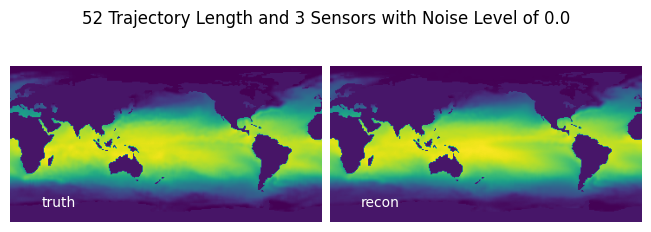

In [10]:
train_dataset, valid_dataset, test_dataset, sc, test_indices = train_test_split()
mse_default = train_and_plot(train_dataset, valid_dataset, test_dataset, sc, test_indices)

### Problem 3

In [11]:
lags = np.arange(26, 260, 13) # 6 months to 5 years

epoch: 1000 valid_error: tensor(0.1123, device='cuda:0'): 100%|██████████| 1000/1000 [02:33<00:00,  6.50it/s]


MSE: 0.01978457160294056 for 26 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 740 valid_error: tensor(0.1104, device='cuda:0'):  74%|███████▍  | 739/1000 [01:55<00:40,  6.43it/s]


MSE: 0.020631009712815285 for 39 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 840 valid_error: tensor(0.1102, device='cuda:0'):  84%|████████▍ | 839/1000 [02:12<00:25,  6.34it/s]


MSE: 0.019823167473077774 for 52 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1083, device='cuda:0'): 100%|██████████| 1000/1000 [02:39<00:00,  6.28it/s]


MSE: 0.01924268715083599 for 65 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1077, device='cuda:0'): 100%|██████████| 1000/1000 [02:41<00:00,  6.18it/s]


MSE: 0.01969967968761921 for 78 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 780 valid_error: tensor(0.1078, device='cuda:0'):  78%|███████▊  | 779/1000 [02:07<00:36,  6.11it/s]


MSE: 0.020148560404777527 for 91 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 760 valid_error: tensor(0.1094, device='cuda:0'):  76%|███████▌  | 759/1000 [02:06<00:40,  6.02it/s]


MSE: 0.020006954669952393 for 104 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 760 valid_error: tensor(0.1099, device='cuda:0'):  76%|███████▌  | 759/1000 [02:08<00:40,  5.91it/s]


MSE: 0.0197400264441967 for 117 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 980 valid_error: tensor(0.1068, device='cuda:0'):  98%|█████████▊| 979/1000 [02:47<00:03,  5.85it/s]


MSE: 0.018994837999343872 for 130 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 680 valid_error: tensor(0.1122, device='cuda:0'):  68%|██████▊   | 679/1000 [01:57<00:55,  5.77it/s]


MSE: 0.020010700449347496 for 143 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1056, device='cuda:0'): 100%|██████████| 1000/1000 [02:55<00:00,  5.71it/s]


MSE: 0.01924099214375019 for 156 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 960 valid_error: tensor(0.1073, device='cuda:0'):  96%|█████████▌| 959/1000 [02:51<00:07,  5.61it/s]


MSE: 0.01942530833184719 for 169 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1009, device='cuda:0'): 100%|██████████| 1000/1000 [03:00<00:00,  5.55it/s]


MSE: 0.01854388788342476 for 182 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.0997, device='cuda:0'): 100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s]


MSE: 0.018417838960886 for 195 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 960 valid_error: tensor(0.1074, device='cuda:0'):  96%|█████████▌| 959/1000 [02:57<00:07,  5.40it/s]


MSE: 0.019884292036294937 for 208 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 860 valid_error: tensor(0.1049, device='cuda:0'):  86%|████████▌ | 859/1000 [02:43<00:26,  5.26it/s]


MSE: 0.01908808760344982 for 221 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 800 valid_error: tensor(0.1042, device='cuda:0'):  80%|███████▉  | 799/1000 [02:31<00:38,  5.26it/s]


MSE: 0.018931584432721138 for 234 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 880 valid_error: tensor(0.1413, device='cuda:0'):  88%|████████▊ | 879/1000 [02:48<00:23,  5.20it/s]


MSE: 0.02627241238951683 for 247 Trajectory Length and 3 Sensors with Noise Level of 0.0


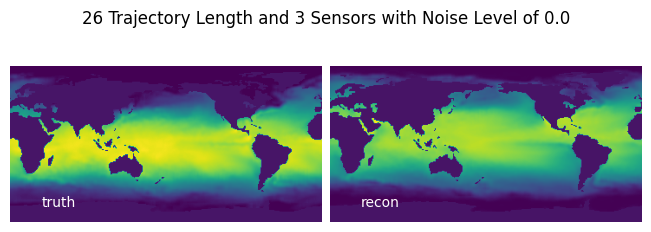

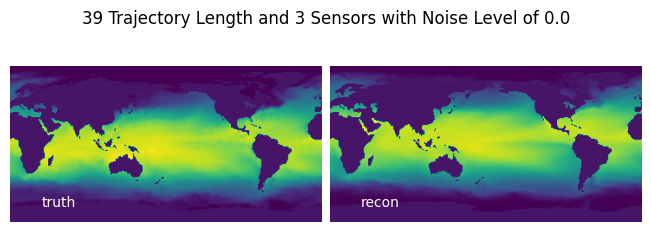

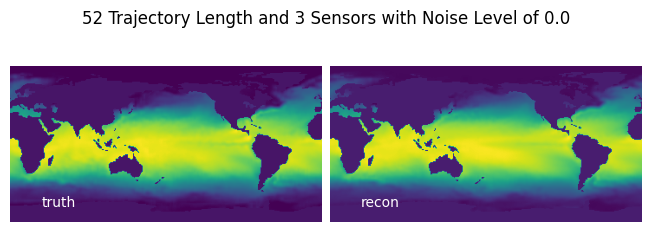

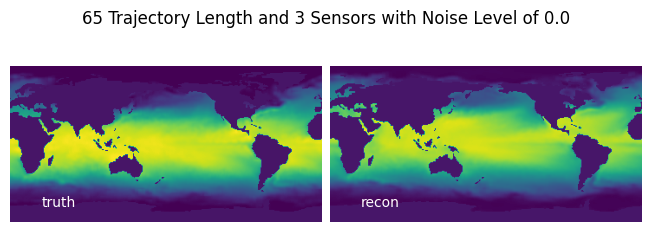

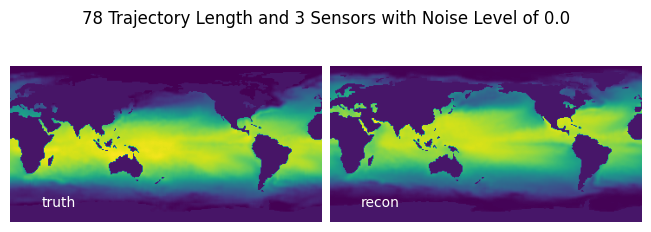

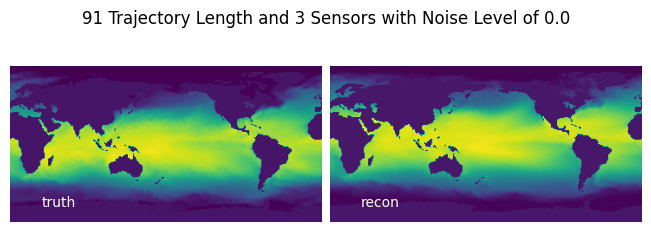

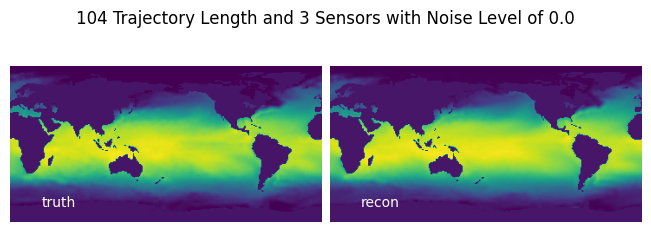

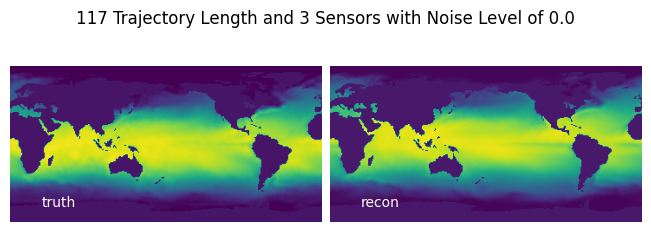

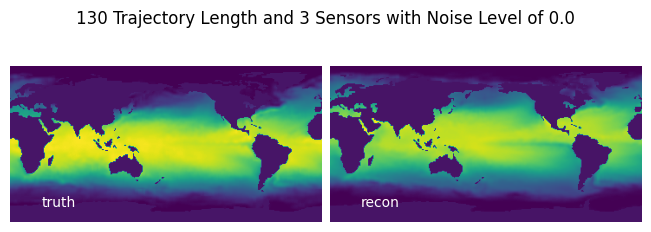

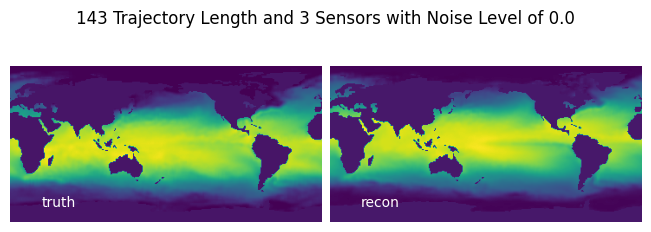

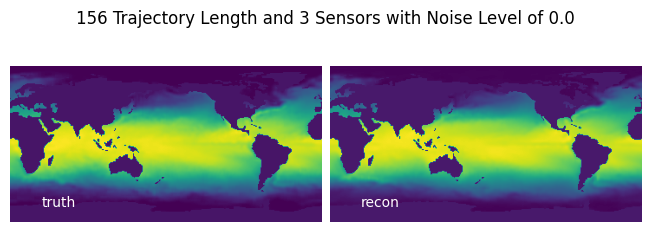

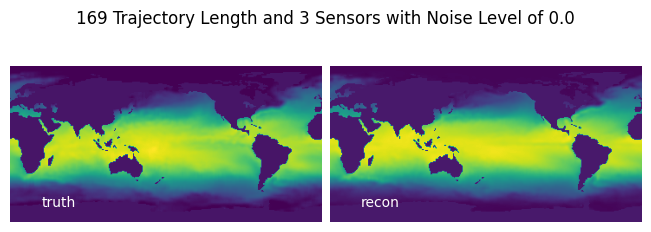

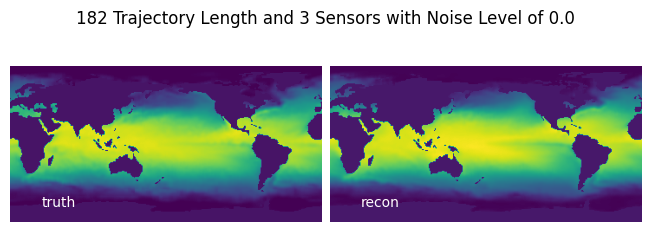

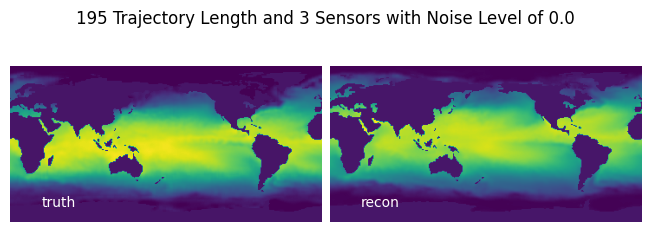

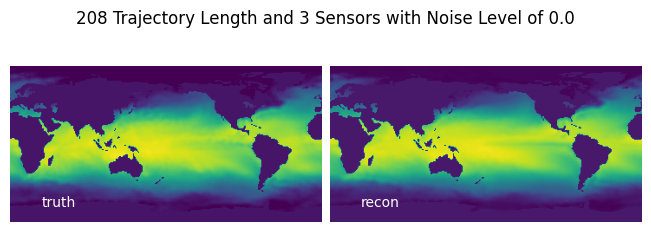

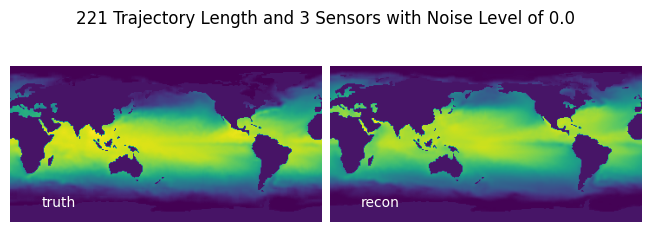

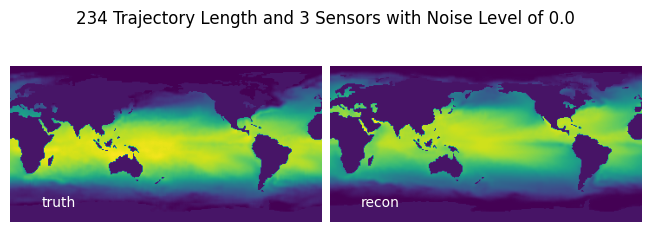

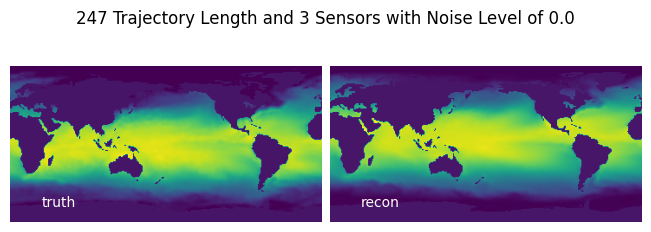

In [12]:
mse_lags = np.ndarray((len(lags)))
for i in range(len(lags)):
  lag = lags[i]
  train_dataset_lags, valid_dataset_lags, test_dataset_lags, sc_lags, test_indices_lags = train_test_split(lags=lag)
  mse_lags[i] = train_and_plot(train_dataset_lags, valid_dataset_lags, test_dataset_lags, sc_lags, test_indices_lags, lag)

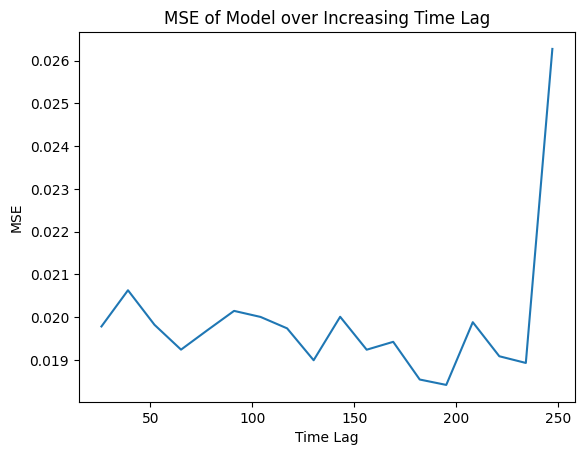

In [13]:
plt.plot(lags, mse_lags)
plt.xlabel("Time Lag")
plt.ylabel("MSE")
plt.title("MSE of Model over Increasing Time Lag")
plt.show()

### Problem 4

In [14]:
noise = np.arange(1, 3, .1)

epoch: 200 valid_error: tensor(0.2617, device='cuda:0'):  20%|█▉        | 199/1000 [00:31<02:06,  6.31it/s]


MSE: 0.05066714808344841 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.0


epoch: 160 valid_error: tensor(0.2421, device='cuda:0'):  16%|█▌        | 159/1000 [00:25<02:13,  6.31it/s]


MSE: 0.047627225518226624 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.1


epoch: 160 valid_error: tensor(0.2592, device='cuda:0'):  16%|█▌        | 159/1000 [00:25<02:13,  6.30it/s]


MSE: 0.047426238656044006 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.2000000000000002


epoch: 120 valid_error: tensor(0.2621, device='cuda:0'):  12%|█▏        | 119/1000 [00:18<02:20,  6.27it/s]


MSE: 0.05134190618991852 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.3000000000000003


epoch: 140 valid_error: tensor(0.2594, device='cuda:0'):  14%|█▍        | 139/1000 [00:22<02:16,  6.30it/s]


MSE: 0.048997778445482254 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.4000000000000004


epoch: 160 valid_error: tensor(0.2739, device='cuda:0'):  16%|█▌        | 159/1000 [00:25<02:13,  6.31it/s]


MSE: 0.052723996341228485 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.5000000000000004


epoch: 120 valid_error: tensor(0.3299, device='cuda:0'):  12%|█▏        | 119/1000 [00:18<02:19,  6.30it/s]


MSE: 0.06668219715356827 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.6000000000000005


epoch: 140 valid_error: tensor(0.2876, device='cuda:0'):  14%|█▍        | 139/1000 [00:22<02:17,  6.28it/s]


MSE: 0.056593965739011765 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.7000000000000006


epoch: 180 valid_error: tensor(0.2713, device='cuda:0'):  18%|█▊        | 179/1000 [00:28<02:11,  6.26it/s]


MSE: 0.04822317510843277 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.8000000000000007


epoch: 120 valid_error: tensor(0.3125, device='cuda:0'):  12%|█▏        | 119/1000 [00:18<02:20,  6.29it/s]


MSE: 0.06308617442846298 for 52 Trajectory Length and 3 Sensors with Noise Level of 1.9000000000000008


epoch: 120 valid_error: tensor(0.4576, device='cuda:0'):  12%|█▏        | 119/1000 [00:18<02:20,  6.27it/s]


MSE: 0.10267322510480881 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.000000000000001


epoch: 120 valid_error: tensor(0.3786, device='cuda:0'):  12%|█▏        | 119/1000 [00:18<02:20,  6.27it/s]


MSE: 0.07892514020204544 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.100000000000001


epoch: 160 valid_error: tensor(0.3906, device='cuda:0'):  16%|█▌        | 159/1000 [00:25<02:13,  6.30it/s]


MSE: 0.08366202563047409 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.200000000000001


epoch: 120 valid_error: tensor(0.4084, device='cuda:0'):  12%|█▏        | 119/1000 [00:18<02:19,  6.30it/s]


MSE: 0.08625110238790512 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.300000000000001


epoch: 140 valid_error: tensor(0.4995, device='cuda:0'):  14%|█▍        | 139/1000 [00:22<02:17,  6.27it/s]


MSE: 0.12001730501651764 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.4000000000000012


epoch: 120 valid_error: tensor(0.5758, device='cuda:0'):  12%|█▏        | 119/1000 [00:18<02:20,  6.28it/s]


MSE: 0.12358444184064865 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.5000000000000013


epoch: 120 valid_error: tensor(0.3888, device='cuda:0'):  12%|█▏        | 119/1000 [00:18<02:20,  6.27it/s]


MSE: 0.08471950143575668 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.6000000000000014


epoch: 160 valid_error: tensor(0.3802, device='cuda:0'):  16%|█▌        | 159/1000 [00:25<02:13,  6.30it/s]


MSE: 0.07693157345056534 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.7000000000000015


epoch: 120 valid_error: tensor(0.6660, device='cuda:0'):  12%|█▏        | 119/1000 [00:18<02:20,  6.29it/s]


MSE: 0.1588391661643982 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.8000000000000016


epoch: 160 valid_error: tensor(0.3140, device='cuda:0'):  16%|█▌        | 159/1000 [00:25<02:13,  6.29it/s]


MSE: 0.06359091401100159 for 52 Trajectory Length and 3 Sensors with Noise Level of 2.9000000000000017


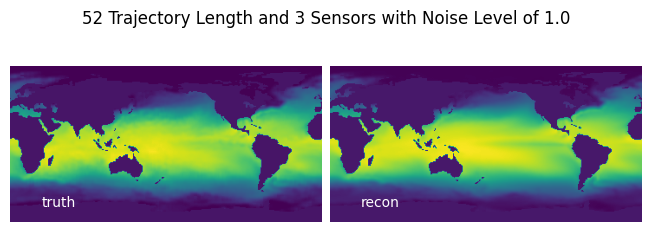

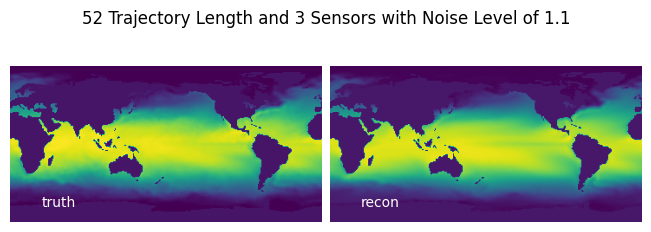

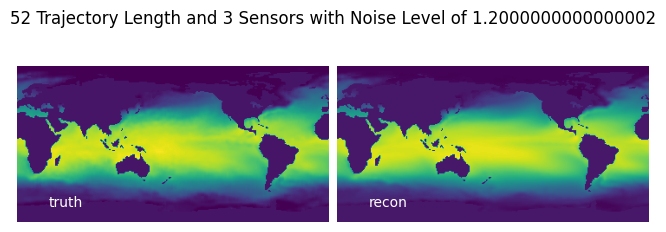

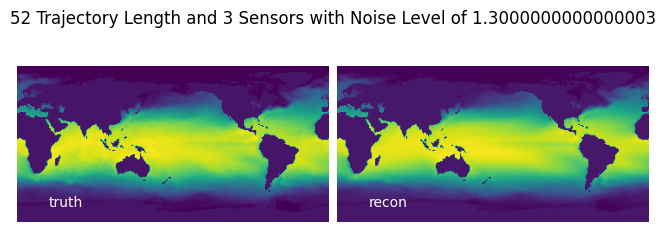

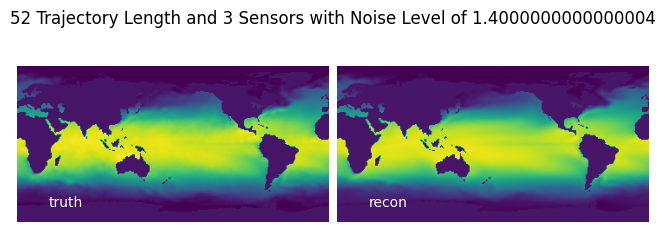

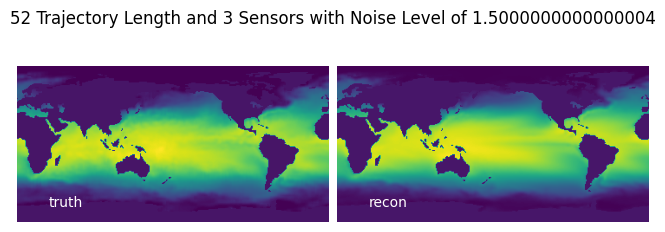

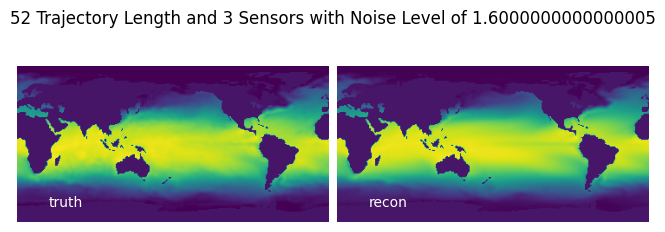

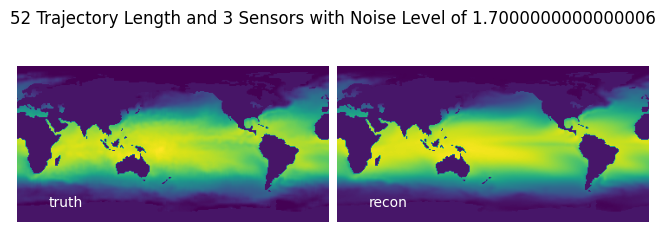

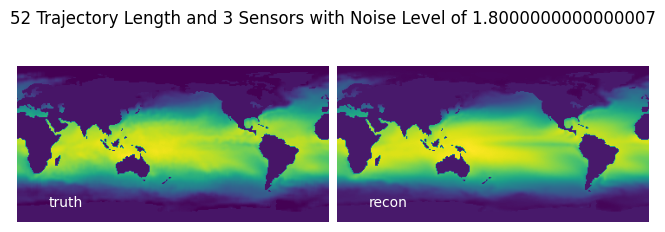

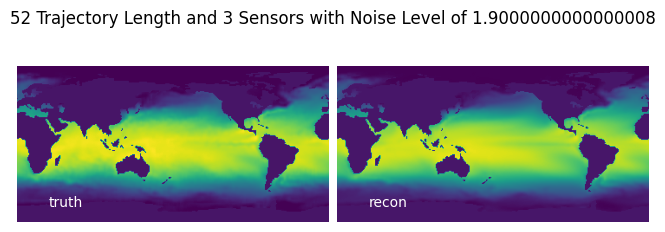

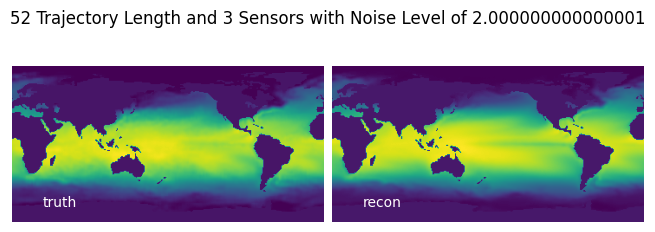

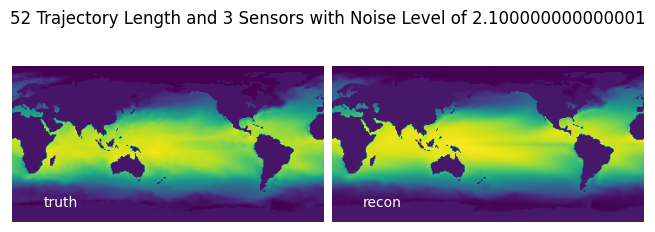

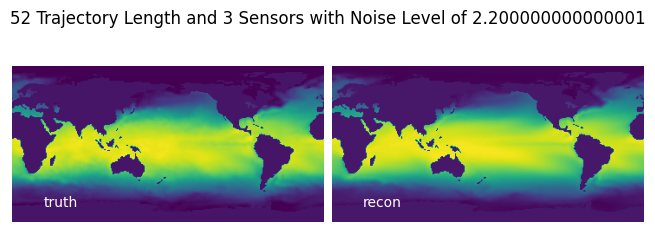

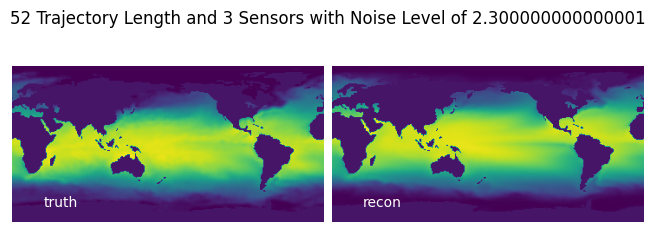

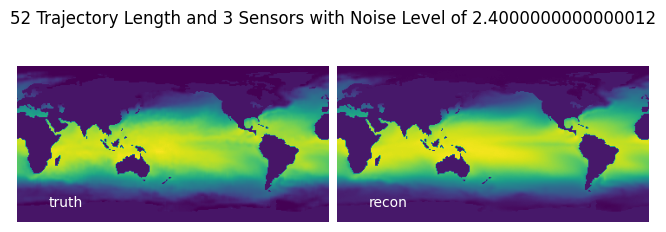

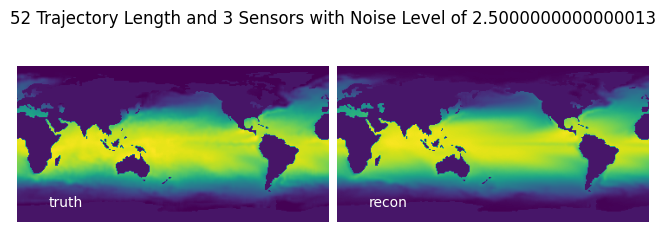

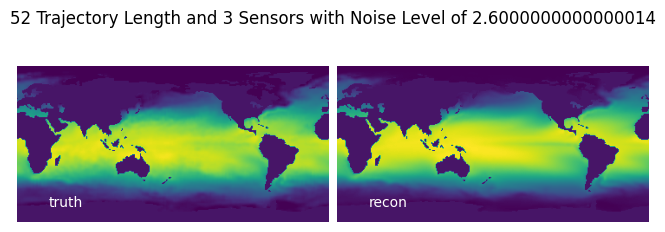

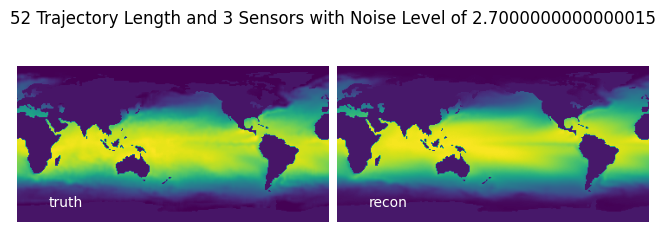

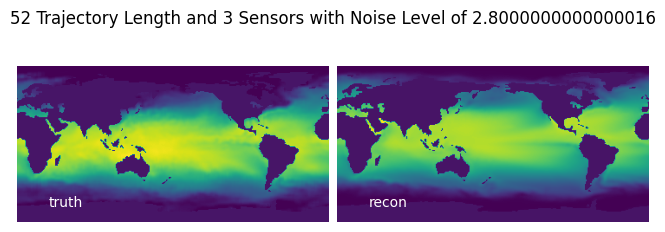

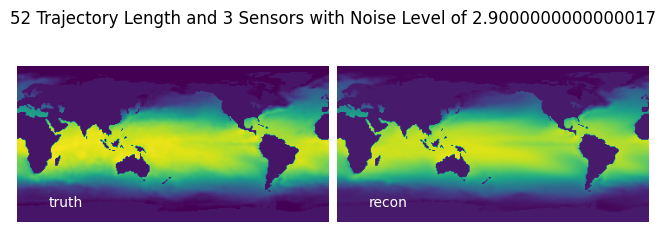

In [15]:
mse_noise = np.ndarray((len(noise)))
for i in range(len(noise)):
  noise_std = noise[i]
  train_dataset_noisy, valid_dataset_noisy, test_dataset_noisy, sc_noisy, test_indices_noisy = train_test_split(noise_std=noise_std)
  mse_noise[i] = train_and_plot(train_dataset_noisy, valid_dataset_noisy, test_dataset_noisy, sc_noisy, test_indices_noisy, noise_std=noise_std)

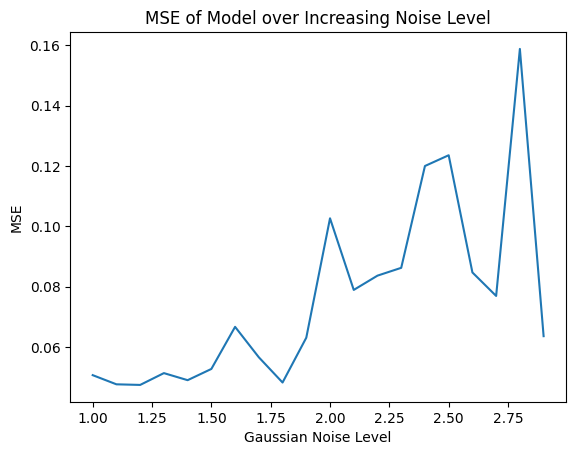

In [16]:
plt.plot(noise, mse_noise)
plt.xlabel("Gaussian Noise Level")
plt.ylabel("MSE")
plt.title("MSE of Model over Increasing Noise Level")
plt.show()

### Problem 5

In [17]:
sensors = np.arange(1, 20)

epoch: 1000 valid_error: tensor(0.1134, device='cuda:0'): 100%|██████████| 1000/1000 [02:38<00:00,  6.29it/s]


MSE: 0.020394427701830864 for 52 Trajectory Length and 1 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1083, device='cuda:0'): 100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]


MSE: 0.020075317472219467 for 52 Trajectory Length and 2 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1102, device='cuda:0'): 100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]


MSE: 0.019647957757115364 for 52 Trajectory Length and 3 Sensors with Noise Level of 0.0


epoch: 840 valid_error: tensor(0.1113, device='cuda:0'):  84%|████████▍ | 839/1000 [02:12<00:25,  6.35it/s]


MSE: 0.020357273519039154 for 52 Trajectory Length and 4 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1090, device='cuda:0'): 100%|█████████▉| 999/1000 [02:37<00:00,  6.34it/s]


MSE: 0.01984601840376854 for 52 Trajectory Length and 5 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1079, device='cuda:0'): 100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]


MSE: 0.019324783235788345 for 52 Trajectory Length and 6 Sensors with Noise Level of 0.0


epoch: 920 valid_error: tensor(0.1069, device='cuda:0'):  92%|█████████▏| 919/1000 [02:24<00:12,  6.34it/s]


MSE: 0.01976275071501732 for 52 Trajectory Length and 7 Sensors with Noise Level of 0.0


epoch: 680 valid_error: tensor(0.1103, device='cuda:0'):  68%|██████▊   | 679/1000 [01:47<00:50,  6.34it/s]


MSE: 0.019581517204642296 for 52 Trajectory Length and 8 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1090, device='cuda:0'): 100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]


MSE: 0.01930483803153038 for 52 Trajectory Length and 9 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1130, device='cuda:0'): 100%|██████████| 1000/1000 [02:37<00:00,  6.35it/s]


MSE: 0.019557343795895576 for 52 Trajectory Length and 10 Sensors with Noise Level of 0.0


epoch: 660 valid_error: tensor(0.1146, device='cuda:0'):  66%|██████▌   | 659/1000 [01:44<00:53,  6.33it/s]


MSE: 0.0206331517547369 for 52 Trajectory Length and 11 Sensors with Noise Level of 0.0


epoch: 800 valid_error: tensor(0.1101, device='cuda:0'):  80%|███████▉  | 799/1000 [02:06<00:31,  6.33it/s]


MSE: 0.019778508692979813 for 52 Trajectory Length and 12 Sensors with Noise Level of 0.0


epoch: 700 valid_error: tensor(0.1090, device='cuda:0'):  70%|██████▉   | 699/1000 [01:50<00:47,  6.33it/s]


MSE: 0.020083589479327202 for 52 Trajectory Length and 13 Sensors with Noise Level of 0.0


epoch: 700 valid_error: tensor(0.1125, device='cuda:0'):  70%|██████▉   | 699/1000 [01:50<00:47,  6.34it/s]


MSE: 0.020258868113160133 for 52 Trajectory Length and 14 Sensors with Noise Level of 0.0


epoch: 920 valid_error: tensor(0.1083, device='cuda:0'):  92%|█████████▏| 919/1000 [02:25<00:12,  6.33it/s]


MSE: 0.019484015181660652 for 52 Trajectory Length and 15 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1089, device='cuda:0'): 100%|██████████| 1000/1000 [02:37<00:00,  6.34it/s]


MSE: 0.019304892048239708 for 52 Trajectory Length and 16 Sensors with Noise Level of 0.0


epoch: 860 valid_error: tensor(0.1072, device='cuda:0'):  86%|████████▌ | 859/1000 [02:15<00:22,  6.32it/s]


MSE: 0.019718943163752556 for 52 Trajectory Length and 17 Sensors with Noise Level of 0.0


epoch: 940 valid_error: tensor(0.1105, device='cuda:0'):  94%|█████████▍| 939/1000 [02:28<00:09,  6.33it/s]


MSE: 0.01915651001036167 for 52 Trajectory Length and 18 Sensors with Noise Level of 0.0


epoch: 1000 valid_error: tensor(0.1050, device='cuda:0'): 100%|██████████| 1000/1000 [02:37<00:00,  6.34it/s]


MSE: 0.01902805268764496 for 52 Trajectory Length and 19 Sensors with Noise Level of 0.0


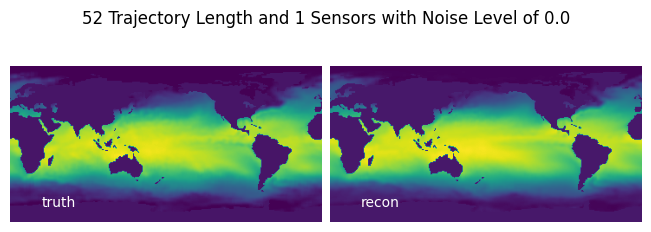

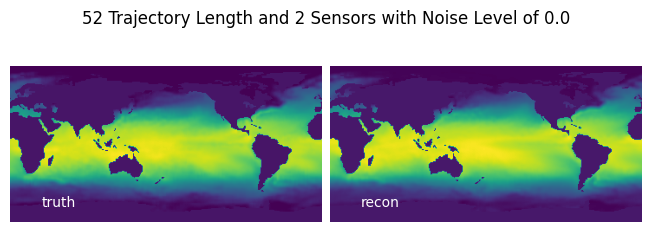

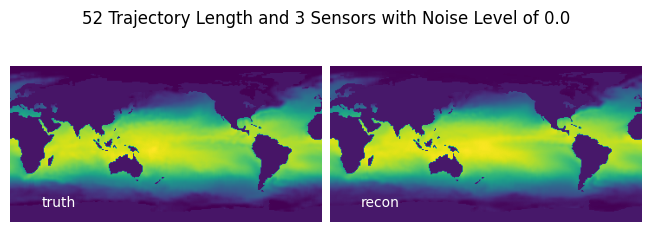

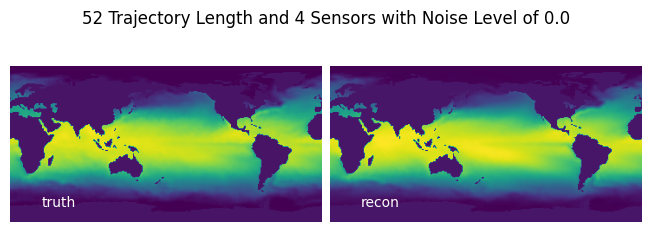

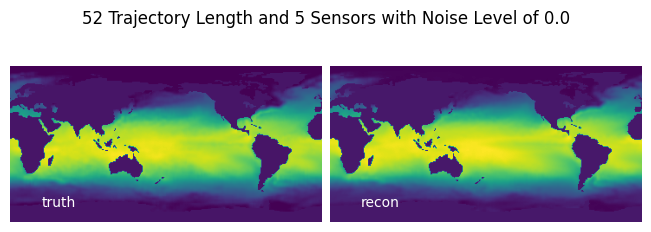

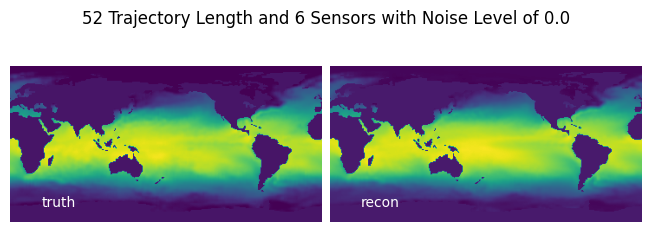

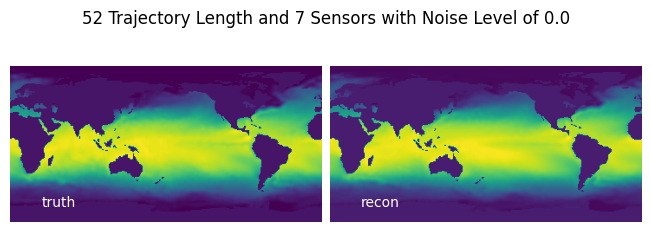

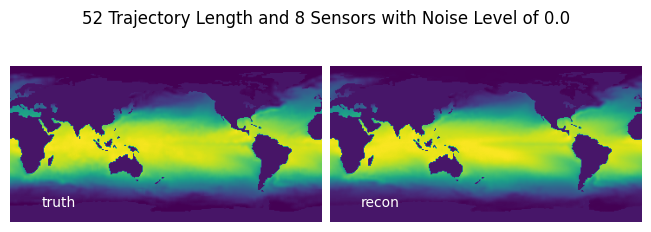

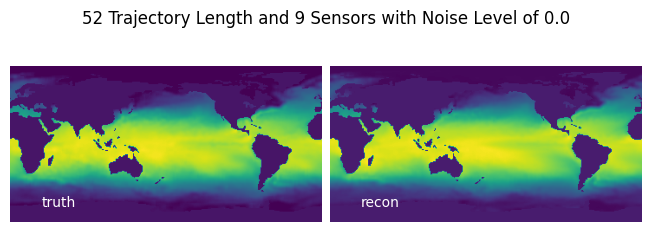

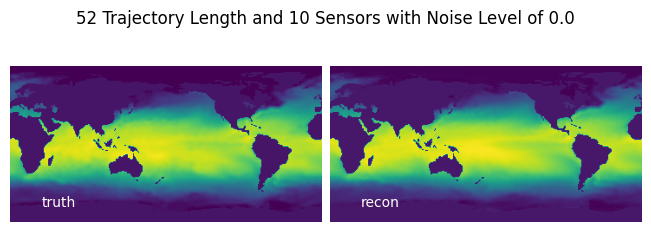

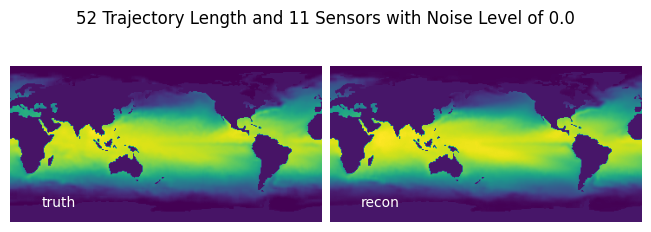

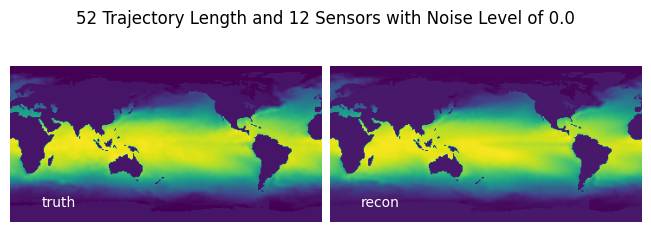

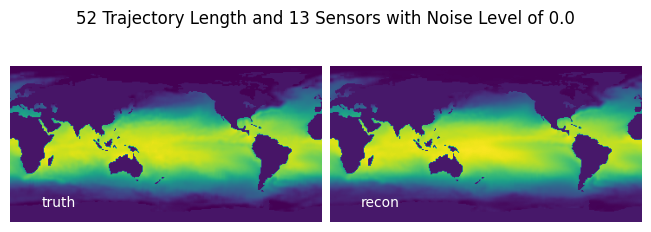

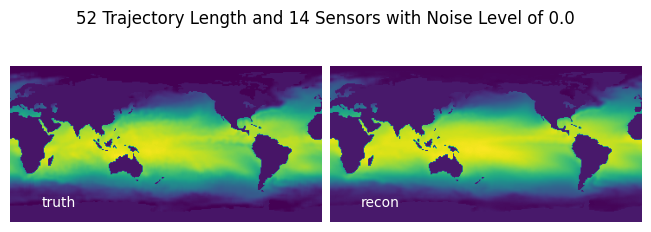

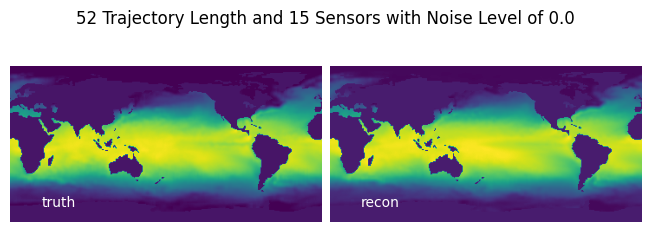

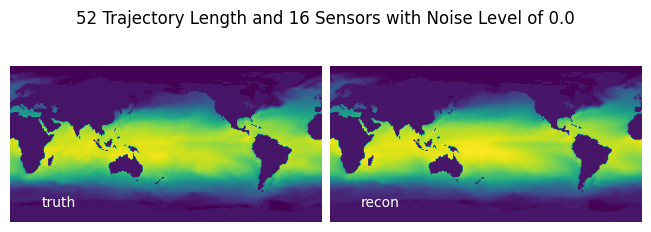

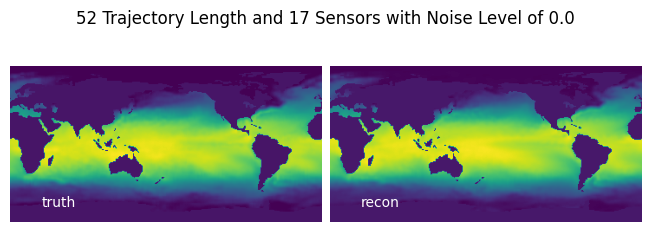

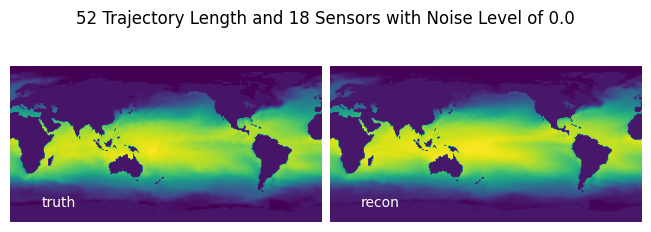

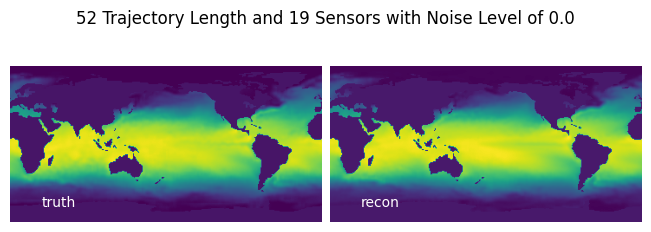

In [18]:
mse_sens = np.ndarray((len(sensors)))
for i in range(len(sensors)):
  sens = sensors[i]
  train_dataset_sens, valid_dataset_sens, test_dataset_sens, sc_sens, test_indices_sens = train_test_split(num_sensors=sens)
  mse_sens[i] = train_and_plot(train_dataset_sens, valid_dataset_sens, test_dataset_sens, sc_sens, test_indices_sens, num_sensors=sens)

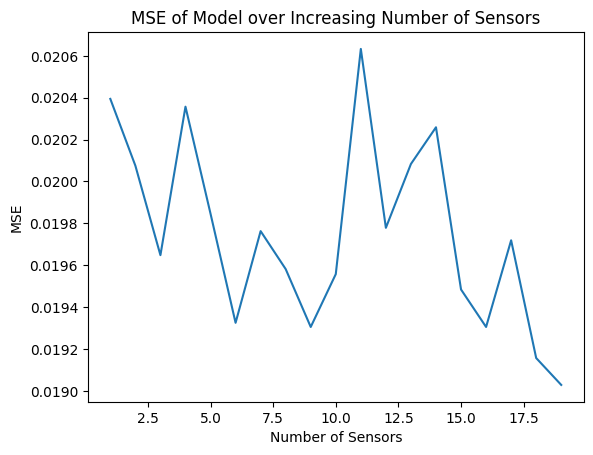

In [19]:
plt.plot(sensors, mse_sens)
plt.xlabel("Number of Sensors")
plt.ylabel("MSE")
plt.title("MSE of Model over Increasing Number of Sensors")
plt.show()